## Question 1

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

prog = Program() # L'objet que nous utilisons pour "accumuler" les portes lors de la construction des circuits.

q = prog.qalloc(2) # Attribution d'un registre de 2 qubits appelé q. Il est adressable avec [.] comme un tableau.
                   # Nous ne travaillerons qu'avec un seul registre dans cette session, mais c'est possible d'en définir plusieurs

prog.apply(H, q[0]) # La première instruction du programme est l'application d'une porte Hadamard sur q[0]

def matrix(alpha):
    Y = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * alpha * Y)

ham_y = AbstractGate("ham_Y", [float], arity=1, matrix_generator=matrix) # définition d'une porte paramétrée personnalisée

prog.apply(ham_y(0.3).ctrl(), q) # La troisième instuction est l'application de notre porte personnalisée sur q[0].

circ = prog.to_circ() # Le programme est exporte dans le circuit.  

# Affichage du circuit:
%qatdisplay --svg circ

# Mise en marche du circuit par le biais du qpu par defaut.
qpu = get_default_qpu()

job = circ.to_job() # Calcul de l'amplitude/probabilite de tout les etats possible.

result = qpu.submit(job)

# amplitude/probabilite de tout les etats possible sont enregistres dans result.
st = -1 # verifie que le calcul s'est bien deroule
for sample in result:
    # affichage des resultats.
    print("state ", sample.state, " has amplitude : ", sample.amplitude, " and probability :", sample.probability)
    st = sample.state

if st.int==-1:
    raise ValueError("no result")  # probleme si st=-1

state  |00>  has amplitude :  (0.7071067811865475+0j)  and probability : 0.4999999999999999
state  |10>  has amplitude :  (0.6755249097756644+0j)  and probability : 0.4563339037274195
state  |11>  has amplitude :  -0.20896434210788314j  and probability : 0.043666096272580425


### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [2]:
#importation des donnees du hamiltonien.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [3]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # comme un Programme, sauf que les portes sont appliquees aux "fils" .
    routine.apply(CNOT, 0, 1)      # numérotés de 0 au numéro max qui a été vu.
    routine.apply(H, 0)
    
    return routine

#Le coller dans un circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Version controllee

circ = prog.to_circ()

%qatdisplay --svg circ        

#### Hamiltonian evolutions to implement

$U_{II} = e^{-i dt II} = e^{-i dt}II$\
$ZZ = CNOT . I\otimes Z . CNOT$ $\implies$ $U_{ZZ}(dt) = CNOT . e^{-i dt I\otimes Z} . CNOT = CNOT . I\otimes RZ(2 dt) . CNOT$\
$U_{IZ}(dt) = e^{-i dt I\otimes Z} = I \otimes e^{-i dt Z} = I \otimes RZ(2 dt)$\
$U_{ZI}(dt) = e^{-i dt Z\otimes I} = e^{-i dt Z} \otimes I = RZ(2 dt) \otimes I$\
$XX = CNOT . X\otimes I . CNOT$ $\implies$ $U_{XX}(dt) = CNOT . e^{-i dt X\otimes I} . CNOT = CNOT . RX(2 dt)\otimes I . CNOT$\
$YX = CNOT . Y\otimes I . CNOT$ $\implies$ $U_{YX}(dt) = CNOT . e^{-i dt Y\otimes I} . CNOT = CNOT . RY(2 dt)\otimes I . CNOT$\
$Y = S . X . S^\dagger \implies Y\otimes Y = I\otimes S . Y\otimes X . (I\otimes S)^\dagger$\
$\implies U_{YY}(dt) = I\otimes S . e^{-i dt Y\otimes X} . (I\otimes S)^\dagger = I\otimes S . U_{YX}(dt) . (I\otimes S)^\dagger$

In [4]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # nécessaires pour obtenir des valeurs énergétiques précises.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])

U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)

# U_ZZ circuit
def U_ZZ(dt):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # différence de convention entre la version implémentée et ce dont nous avons besoin.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

prog = Program()
q = prog.qalloc(2)
prog.apply(U_ZZ(3.), q)
circ_ZZ = prog.to_circ()

# U_ZI circuit
def U_ZI(dt):
    zi_r = QRoutine()
    zi_r.apply(RZ(2*dt), 0)
    zi_r.apply(I, 1)
    return zi_r

prog = Program()
q = prog.qalloc(2)
prog.apply(U_ZI(3.), q)
circ_ZI = prog.to_circ()

# U_IZ circuit
def U_IZ(dt):
    iz_r = QRoutine()
    iz_r.apply(RZ(2*dt), 1)
    iz_r.apply(I, 0)
    return iz_r

prog = Program()
q = prog.qalloc(2)
prog.apply(U_IZ(3.), q)
circ_IZ = prog.to_circ()

# U_XX circuit
def U_XX(dt):
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0)
    xx_r.apply(CNOT, 0, 1)
    return xx_r

prog = Program()
q = prog.qalloc(2)
prog.apply(U_XX(3.), q)
circ_XX = prog.to_circ()

#U_YX circuit
def U_YX(dt):
    yx_r = QRoutine()
    yx_r.apply(CNOT, 0, 1)
    yx_r.apply(RY(2*dt), 0)
    yx_r.apply(CNOT, 0, 1)
    return yx_r

prog = Program()
q = prog.qalloc(2)
prog.apply(U_YX(3.), q)
circ_YX = prog.to_circ()

# U_YY circuit
def U_YY(dt):
    yy_r = QRoutine()
    yy_r.apply(S.dag(), 1)
    yy_r.apply(U_YX(dt), 0, 1) 
    yy_r.apply(S, 1)
    return yy_r    

prog = Program()
q = prog.qalloc(2)
prog.apply(U_YY(3.), q)
circ_YY = prog.to_circ()

##décommenter la ligne suivante pour tracer le circuit
%qatdisplay --svg circ_ZZ 
%qatdisplay --svg circ_ZI
%qatdisplay --svg circ_IZ
%qatdisplay --svg circ_XX
%qatdisplay --svg circ_YX
%qatdisplay --svg circ_YY

### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [5]:
def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: un dictionnaire de la liste des dictionnaires chargés à partir de hamiltonian_data.json.
        Ses clés sont donc "I_coeff", "Z0_coeff", etc.
        - dt: un flottant, correspondant à l'intervalle de temps dont nous définirons la valeur plus tard.
        - p: le "nombre de Trotter" : le nombre entier contrôlant le degré d'approximation
        - shift: un déplacement d'énergie à l'hamiltonien pour s'assurer que la valeur de l'énergie de l'état fondamental
        soit positive. Elle consiste à ajouter +shift*I à l'hamiltonien.
    """
    if p<1:
        raise ValueError("p has to be strictly positive")
    
    ham_gate = {'I_coeff': U_II,
                'Z0_coeff': U_ZI,
                'Z1_coeff': U_IZ,
                'Z0Z1_coeff': U_ZZ,
                'X0X1_coeff': U_XX,
                'Y0Y1_coeff': U_YY}
    ham_coeffs['I_coeff'] += shift
    ham_gate_list = ham_gate.keys()
    qroutine = QRoutine()
    
    for i in range(p):
        for gate in ham_gate_list:
            qroutine.apply(ham_gate[gate](ham_coeffs[gate]*dt/p), 0, 1)
    
    return qroutine

Let's test this routine on a Hamiltonian

In [6]:
ham_coeffs = {'I_coeff': 2.8489,
              'Z0_coeff': 0.5678,
              'Z1_coeff': -1.4508,
              'Z0Z1_coeff': 0.6799,
              'X0X1_coeff': 0.0791,
              'Y0Y1_coeff': 0.0791}
dt = 1
p = 2
shift = 2.8489

prog = Program()
q = prog.qalloc(2)
prog.apply(trotter_ham_simulation(ham_coeffs, dt, p, shift), q)
circ_trotter = prog.to_circ()
%qatdisplay --svg circ_trotter

In [7]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)

    return qroutine

Let's verify that we obtain same probabilities with the two routines

In [9]:
ham_coeffs = {'I_coeff': 2.8489,
              'Z0_coeff': 0.5678,
              'Z1_coeff': -1.4508,
              'Z0Z1_coeff': 0.6799,
              'X0X1_coeff': 0.0791,
              'Y0Y1_coeff': 0.0791}
dt = 0.0791
p = 2
shift = 0.0

prog = Program()
q = prog.qalloc(2)
prog.apply(trotter_ham_simulation(ham_coeffs, dt, p, shift), q)
circ_trotter = prog.to_circ()
# %qatdisplay --svg circ_trotter

prog = Program()
q = prog.qalloc(2)
prog.apply(perfect_ham_simulation(ham_coeffs, dt, shift), q)
circ_perfect = prog.to_circ()
# %qatdisplay --svg circ_perfect

qpu = get_default_qpu()

job_trotter = circ_trotter.to_job() # Calcul de l'amplitude/probabilite de tout les etats possible.
job_perfect = circ_perfect.to_job() # Calcul de l'amplitude/probabilite de tout les etats possible.

result_trotter = qpu.submit(job_trotter)
result_perfect = qpu.submit(job_perfect)

#l'amplitude/probabilite de tout les etats possible sont enregistrees dans result.
st = -1 # verifie que le calcul s'est bien deroule.
print("Amplitude and Probabilities with the trotter implementation")
for sample in result_trotter:
    # affichage des resultats.
    print("state ", sample.state, " has amplitude : ", sample.amplitude, " and probability :", sample.probability)
    st = sample.state

print("Amplitude and Probabilities with the perfect implementation")
for sample in result_perfect:
    # affichage des resultats.
    print("state ", sample.state, " has amplitude : ", sample.amplitude, " and probability :", sample.probability)
    st = sample.state


Amplitude and Probabilities with the trotter implementation
state  |00>  has amplitude :  (0.9781801747689421-0.2077583829572244j)  and probability : 0.9999999999999989
Amplitude and Probabilities with the perfect implementation
state  |00>  has amplitude :  (0.9781801747689426-0.20775838295722449j)  and probability : 0.9999999999999998


### Conclusion
For a small shift, the difference in amplitude is very small. The Trotter method seems to provide a very good estimation of the probability

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

In [11]:
from qat.lang.AQASM import X

E_max = 3  # Energie maximale.
E_min = -2  # Energie minimale.
    
dt = (2 * np.pi) / float(E_max)

def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """    
    bits = {}

    for k in range(nBits, 0, -1):
        
        # Computation of phi_k
        phi_k = 0
        for i in range(k+1, nBits+1):
            phi_k += bits[i]/2**(i-k+1)
        phi_k = 2*np.pi*phi_k
        
        # CIRCUIT CREATION
        prog = Program()
        q = prog.qalloc(3)
        prog.apply(H, q[0])
        prog.apply(X, q[1])
        
        if trotterization:
            prog.apply(trotter_ham_simulation(coeffs, 2**(k-1)*dt, trotter_number, shift).ctrl(),q)
        else:
            prog.apply(perfect_ham_simulation(coeffs, 2**(k-1)*dt, shift).ctrl(), q)
        
        prog.apply(RZ(phi_k), q[0])
        prog.apply(H, q[0])

        # CIRCUIT SIMULATION
        job = prog.to_circ().to_job(qubits=[0])

        result = qpu.submit(job)

        # SELECTION OF MOST LIKELY RESULT
        likely_state = 0
        best_proba = 0
        for res in result:
            if res.probability >= best_proba:
                likely_state = res.state.int
                best_proba = res.probability
        
        bits[k] = likely_state
    
    # recompute phi
    phi = 0
    for k in range(1, nBits+1):
        phi += bits[k]/2**k
        
    return phi

### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [12]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)
    
    E = 2*np.pi*phi_perfect/dt
    E_trotter_4 = 2*np.pi*phi_trotter_4/dt
    E_trotter_10 = 2*np.pi*phi_trotter_10/dt
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)


R 0.2
R 0.25
R 0.3
R 0.35
R 0.4
R 0.45
R 0.5
R 0.55
R 0.6
R 0.65
R 0.7
R 0.75
R 0.8
R 0.85
R 0.9
R 0.95
R 1.0
R 1.05
R 1.1
R 1.15
R 1.2
R 1.25
R 1.3
R 1.35
R 1.4
R 1.45
R 1.5
R 1.55
R 1.6
R 1.65
R 1.7
R 1.75
R 1.8
R 1.85
R 1.9
R 1.95
R 2.0
R 2.05
R 2.1
R 2.15
R 2.2
R 2.25
R 2.3
R 2.35
R 2.4
R 2.45
R 2.5
R 2.55
R 2.6
R 2.65
R 2.7
R 2.75
R 2.8
R 2.85


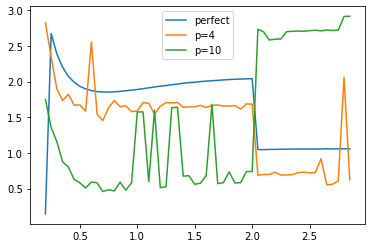

In [35]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
plt.plot(Rs, vals_trotter_4, label="p=4")
plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()